In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# import xgboost as xgb
from scipy.stats import zscore
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

%matplotlib inline

In [4]:
pd.set_option('display.float_format', lambda x: '{:.4f}'.format(x))
plt.rcParams['figure.figsize'] = [9,5]
plt.style.use('ggplot')

Changing the Defaults: rcParams
Each time Matplotlib loads, it defines a runtime configuration (rc) containing the default styles for every plot element you create. This configuration can be adjusted at any time using the plt. rc convenience routine.
The figsize attribute allows us to specify the width and height of a figure in unit inches

## Load & Describe Dataset

In [5]:
data_df = pd.read_csv('forestfires.csv')

In [6]:
data_df.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2000,26.2000,94.3000,5.1000,8.2000,51,6.7000,0.0000,0.0000
1,7,4,oct,tue,90.6000,35.4000,669.1000,6.7000,18.0000,33,0.9000,0.0000,0.0000
2,7,4,oct,sat,90.6000,43.7000,686.9000,6.7000,14.6000,33,1.3000,0.0000,0.0000
3,8,6,mar,fri,91.7000,33.3000,77.5000,9.0000,8.3000,97,4.0000,0.2000,0.0000
4,8,6,mar,sun,89.3000,51.3000,102.2000,9.6000,11.4000,99,1.8000,0.0000,0.0000


In [7]:
data_df.columns

Index(['X', 'Y', 'month', 'day', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH',
       'wind', 'rain', 'area'],
      dtype='object')

In [8]:
data_df.shape

(517, 13)

In [9]:
target = 'area'

In [10]:
data_df.dtypes

X          int64
Y          int64
month     object
day       object
FFMC     float64
DMC      float64
DC       float64
ISI      float64
temp     float64
RH         int64
wind     float64
rain     float64
area     float64
dtype: object

In [11]:
data_df.describe()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
count,517.0000,517.0000,517.0000,517.0000,517.0000,517.0000,517.0000,517.0000,517.0000,517.0000,517.0000
mean,4.6692,4.2998,90.6447,110.8723,547.9400,9.0217,18.8892,44.2882,4.0176,0.0217,12.8473
std,2.3138,1.2299,5.5201,64.0465,248.0662,4.5595,5.8066,16.3175,1.7917,0.2960,63.6558
min,1.0000,2.0000,18.7000,1.1000,7.9000,0.0000,2.2000,15.0000,0.4000,0.0000,0.0000
25%,3.0000,4.0000,90.2000,68.6000,437.7000,6.5000,15.5000,33.0000,2.7000,0.0000,0.0000
50%,4.0000,4.0000,91.6000,108.3000,664.2000,8.4000,19.3000,42.0000,4.0000,0.0000,0.5200
75%,7.0000,5.0000,92.9000,142.4000,713.9000,10.8000,22.8000,53.0000,4.9000,0.0000,6.5700
max,9.0000,9.0000,96.2000,291.3000,860.6000,56.1000,33.3000,100.0000,9.4000,6.4000,1090.8400


As we can see, the count of every feature column is the same as the shape of the dataset. We observe that 50% (the middle of the data) also called median of feature columns('X', 'Y', 'DMC', 'ISI', 'RH', 'wind', 'rain', 'area') have higher mean value than median i.e data is right skewed. In all feature columns, column: 'area' is highly skewed.

How do you handle right-skewed data?
Here data are right-skewed, i.e., clustered at lower values. For a right skewed distribution, the mean is typically greater than the median. Also, the tail of the distribution on the right hand (positive) side is longer than on the left hand side. We will perform operations like:- square root, cube root, logarithmic, etc. to transform the data. If the data are left-skewed (clustered at higher values). We will perform operations like:- cube, square, etc.

In [12]:
data_mis = (data_df.isnull().sum() / len(data_df)) * 100
data_mis = data_mis.drop(data_mis[data_mis == 0].index).sort_values(ascending=False)
data_mis 

Series([], dtype: float64)

In [13]:
data_mis = pd.DataFrame({'Percentage': data_mis})
data_mis['Id'] = data_mis.index
data_mis.reset_index(drop=True, level=0, inplace=True)
data_mis.head()

,Percentage,Id


In [14]:
dft = data_df.drop(columns=target)
cate_columns = dft.select_dtypes(include='object').columns.tolist()
nume_columns = dft.select_dtypes(exclude='object').columns.tolist()

In [15]:
print('Categorical columns:', cate_columns)

Categorical columns: ['month', 'day']


In [16]:
print('Numerical columns: ', nume_columns)

Numerical columns:  ['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain']


In [17]:
print('Skew: \n{}'.format(data_df.skew()))

Skew: 
X       0.0362
Y       0.4173
FFMC   -6.5756
DMC     0.5475
DC     -1.1004
ISI     2.5363
temp   -0.3312
RH      0.8629
wind    0.5710
rain   19.8163
area   12.8469
dtype: float64


In [18]:
print('Kurtosis: \n {}'.format(data_df.kurtosis()))

Kurtosis: 
 X       -1.1723
Y        1.4206
FFMC    67.0660
DMC      0.2048
DC      -0.2452
ISI     21.4580
temp     0.1362
RH       0.4382
wind     0.0543
rain   421.2960
area   194.1407
dtype: float64


Skew is the degree of distortion from a normal distribution. Skewed, meaning there are a minority of very large values.
Why do we care if the data is skewed? If the response variable is skewed, the model will be trained on a much larger number of moderate observations, and will be less likely to successfully predict the price for the most expensive houses. The concept is the same as training a model on imbalanced categorical classes. If the values of a certain independent variable (feature) are skewed, depending on the model, skewness may violate model assumptions (e.g. logistic regression) or may impair the interpretation of feature importance.

Kurtosis is all about the tails of the distribution — not the peakedness or flatness. It is used to describe the extreme values in one versus the other tail. It is actually the measure of outliers present in the distribution . High kurtosis in a data set is an indicator that data has heavy tails or outliers.
Kurtosis is a measure of whether the data are heavy-tailed (profusion of outliers) or light-tailed (lack of outliers) relative to a normal distribution. Mesokurtic is the distribution which has similar kurtosis as normal distribution kurtosis, which is zero.

If skewness is positive, the data are positively skewed or skewed right, meaning that the right tail of the distribution is longer than the left. If skewness is negative, the data are negatively skewed or skewed left, meaning that the left tail is longer.

If skewness is less than −1 or greater than +1, the distribution is highly skewed.
If skewness is between −1 and −½ or between +½ and +1, the distribution is moderately skewed.
If skewness is between −½ and +½, the distribution is approximately symmetric.


A normal distribution has kurtosis exactly 3 (excess kurtosis exactly 0). Any distribution with kurtosis ≈3 (excess ≈0) is called mesokurtic.
A distribution with kurtosis <3 (excess kurtosis <0 ) is called platykurtic. Compared to a normal distribution, its tails are shorter and thinner, and often its central peak is lower and broader.
A distribution with kurtosis >3 (excess kurtosis >0) is called leptokurtic. Compared to a normal distribution, its tails are longer and fatter, and often its central peak is higher and sharper.

Feature columns:- 'ISI', & 'rain' have +ve skewness, value more than +1 so, they are right skewed.

Feature columns:- 'FFMC', & 'temp' have -ve skewness, value less than -1 so, they are left skewed.

Feature columns:- 'FFMC', 'ISI', & 'rain' have higher kurtosis value. i,e have outliers.

Feature columns with (high, +ve, or -ve) outliers, skewness and kurtosis are:

FFMC
ISI
rain

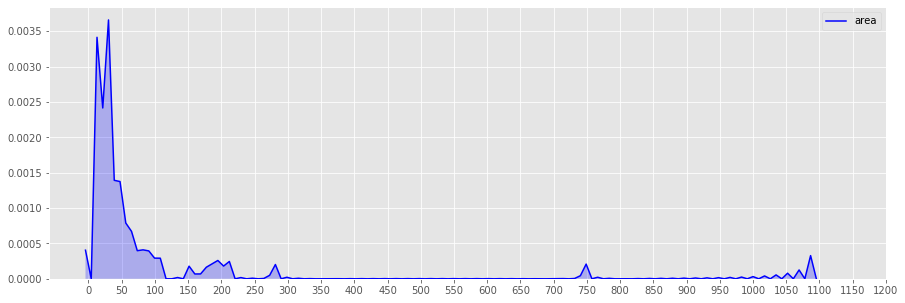

In [19]:
plt.figure(figsize=(15,5))
ax = sns.kdeplot(data_df[target], shade=True, color='b')
plt.xticks([i for i in range(0, 1250, 50)])
plt.show()

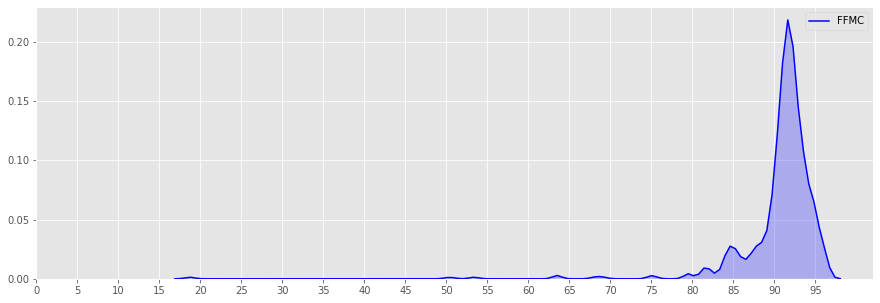

In [20]:
plt.figure(figsize=(15,5))
ax = sns.kdeplot(data_df['FFMC'], shade=True, color='b')
plt.xticks([i for i in range(0, 100, 5)])
plt.show()

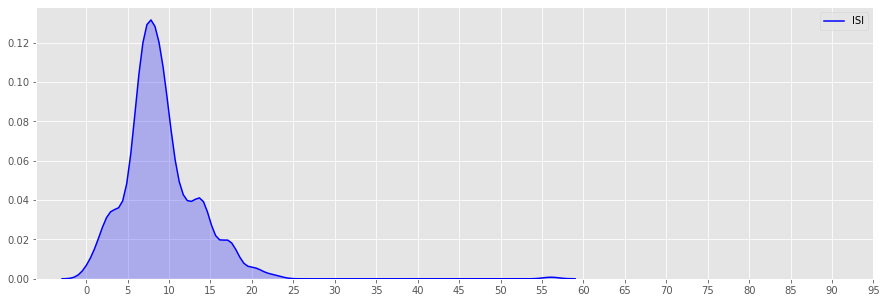

In [21]:
plt.figure(figsize=(15,5))
ax = sns.kdeplot(data_df['ISI'], shade=True, color='b')
plt.xticks([i for i in range(0, 100, 5)])
plt.show()

## OUTLIER ANALYSIS

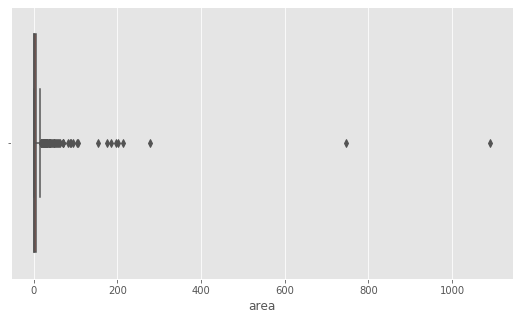

In [22]:
outl_dect = sns.boxplot(data_df[target])

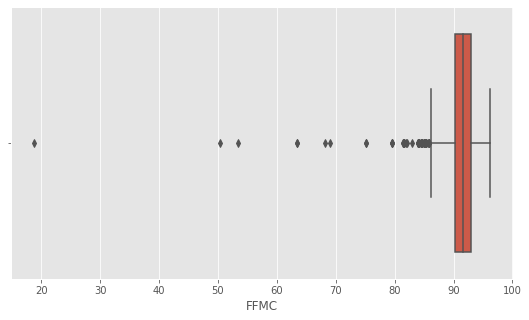

In [23]:
outl_dect = sns.boxplot(data_df['FFMC'])

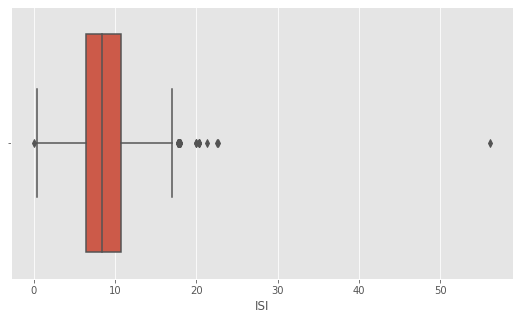

In [24]:
outl_dect = sns.boxplot(data_df['ISI'])

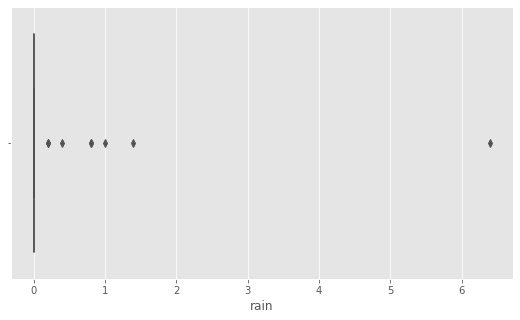

In [25]:
outl_dect = sns.boxplot(data_df['rain'])

In [29]:
outlier_columns = ['area', 'FFMC', 'ISI', 'rain']


In [32]:
(data_df[outlier_columns]).skew()

area   12.8469
FFMC   -6.5756
ISI     2.5363
rain   19.8163
dtype: float64

In [34]:
np.log1p(data_df[outlier_columns]).skew()

area     1.2178
FFMC   -11.6754
ISI     -0.9372
rain    14.1730
dtype: float64

In [35]:
(data_df[outlier_columns]).kurtosis()

area   194.1407
FFMC    67.0660
ISI     21.4580
rain   421.2960
dtype: float64

In [31]:
np.log1p(data_df[outlier_columns]).kurtosis()

area     0.9457
FFMC   185.4824
ISI      2.5846
rain   234.2400
dtype: float64

Even after transformation we still have high skewness and kurtosis in FFMC & rain

So we remove outliers by z-score method.

In [36]:
mask = data_df.loc[: , ['FFMC']].apply(zscore).abs() < 3

In [37]:
mask.values

array([[ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [

In [38]:
data_df = data_df[mask.values]
data_df.shape

(510, 13)

In [39]:
data_df.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2000,26.2000,94.3000,5.1000,8.2000,51,6.7000,0.0000,0.0000
1,7,4,oct,tue,90.6000,35.4000,669.1000,6.7000,18.0000,33,0.9000,0.0000,0.0000
2,7,4,oct,sat,90.6000,43.7000,686.9000,6.7000,14.6000,33,1.3000,0.0000,0.0000
3,8,6,mar,fri,91.7000,33.3000,77.5000,9.0000,8.3000,97,4.0000,0.2000,0.0000
4,8,6,mar,sun,89.3000,51.3000,102.2000,9.6000,11.4000,99,1.8000,0.0000,0.0000


 Since most of the values in rain are 0.0, we convert it to a categorical column

In [40]:
data_df['rain'] = data_df['rain'].apply(lambda x: int(x > 0.0))

In [41]:
data_df['rain']

0      0
1      0
2      0
3      1
4      0
      ..
512    0
513    0
514    0
515    0
516    0
Name: rain, Length: 510, dtype: int64

In [42]:
outlier_columns.remove('rain')
data_df[outlier_columns] = np.log1p(data_df[outlier_columns])

In [43]:
data_df[outlier_columns].skew()

area    1.2085
FFMC   -1.8040
ISI    -0.4344
dtype: float64

In [44]:
data_df[outlier_columns].kurtosis()

area   0.9234
FFMC   4.8667
ISI    1.1226
dtype: float64

In [45]:
data_df.describe()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
count,510.0000,510.0000,510.0000,510.0000,510.0000,510.0000,510.0000,510.0000,510.0000,510.0000,510.0000
mean,4.6804,4.2941,4.5226,111.8376,550.4704,2.2285,18.9516,44.0294,4.0173,0.0157,1.1214
std,2.3205,1.2346,0.0350,63.8537,246.6307,0.4288,5.7899,15.9683,1.7888,0.1244,1.4014
min,1.0000,2.0000,4.3320,3.0000,7.9000,0.7419,2.2000,15.0000,0.4000,0.0000,0.0000
25%,3.0000,4.0000,4.5142,73.2500,442.3000,2.0412,15.6250,32.2500,2.7000,0.0000,0.0000
50%,4.0000,4.0000,4.5288,108.4000,664.2000,2.2407,19.3000,41.5000,4.0000,0.0000,0.4572
75%,7.0000,5.0000,4.5422,142.4000,714.2000,2.4849,22.8000,53.0000,4.9000,0.0000,2.0252
max,9.0000,9.0000,4.5768,291.3000,860.6000,4.0448,33.3000,99.0000,9.4000,1.0000,6.9956


Dataset is ready for model preparation.

In [46]:
data_sel = data_df.copy()

In [47]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
reg = linear_model.LinearRegression()

In [48]:
le = LabelEncoder()
data_sel['day'] = le.fit_transform(data_sel['day'])
data_sel['month'] = le.fit_transform(data_sel['month'])

In [49]:
X,y = data_sel.iloc[: , :-1], data_sel.iloc[: , -1]

In [50]:
X_train,X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7)

In [62]:
reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [63]:
reg.intercept_, reg.coef_

(1.6417463050032381,
 array([ 7.47614323e-02, -2.43439875e-02,  1.66774633e-02,  7.90570777e-03,
        -2.71367806e-01,  2.96121350e-03, -1.11778622e-04, -1.60820233e-01,
         1.23495859e-02, -2.87902858e-03,  9.77290916e-02, -8.07246273e-01]))

In [64]:
preds = reg.predict(X_test)

In [65]:
preds

array([1.29794905, 1.15898998, 0.75216266, 1.61525909, 1.39227756,
       1.56188969, 1.19870779, 1.09608566, 1.17167225, 1.13343101,
       0.40907895, 1.13362875, 1.56564171, 0.99604602, 0.82816619,
       1.23919482, 0.75824127, 1.38667828, 1.24729073, 1.21183318,
       1.1951888 , 1.5476129 , 1.23077581, 1.40139933, 1.32133317,
       1.14503565, 1.03152235, 1.0626838 , 1.26812433, 1.73650569,
       1.33150231, 1.66341943, 1.20337439, 0.96088396, 1.38485278,
       0.6608808 , 1.26173134, 1.09608566, 1.18053929, 0.96010742,
       1.40215015, 1.24862032, 0.94193526, 1.23509638, 1.04548183,
       0.96214324, 1.04058836, 1.17374221, 0.94752804, 1.28083585,
       1.07645099, 1.25706112, 1.19695381, 1.58531618, 1.77448936,
       1.31181047, 1.00817166, 1.49785693, 1.18796292, 1.7908271 ,
       0.90690908, 1.36889747, 0.93560073, 1.00435457, 1.27733139,
       0.43586139, 1.94660205, 1.03140026, 1.14434305, 1.02967161,
       0.53578267, 1.41365046, 1.68242372, 0.8812939 , 1.28246

In [66]:
def cal_ISE(X_train, y_train, model):
    predictions = model.predict(X_train)
    mse = mean_squared_error(y_train, predictions)
    rmse = np.sqrt(mse)
    return model.score(X_train, y_train), rmse

In [67]:
def cal_OSE(X_test, y_test, model):
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    return model.score(X_test, y_test), rmse

In [68]:
is_r2, ise = cal_ISE(X_train, y_train, reg)
os_r2, ose = cal_OSE(X_test, y_test, reg)

In [69]:
data_list = (('R^2_in ',is_r2), ('R^2_out ', os_r2), ('ISE ', ise), ('OSE', ose))

In [70]:
for item in data_list:
    print('{:10}: {}' .format(item[0], item[1]))

R^2_in    : 0.035284100732367984
R^2_out   : -0.007850852062401659
ISE       : 1.3848983999218563
OSE       : 1.375142237352548


Clearly test error(OSE) is near to the training error(ISE). i.e our model is ok.
OSE: Out of sample Error
ISE: In-sample Error

In [72]:
print('train/test:', ose/ise)

train/test: 0.9929553225205121


In [73]:
rmse = np.sqrt(mean_squared_error(y_test, preds))
print('RMSE: ', rmse)

RMSE:  1.375142237352548
